# GENERACION DEL MODELO PREDICTIVO

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install nbimporter
#!pip install tensorflow-addons

In [3]:
import nbimporter
import importlib

In [4]:
import Functions_for_FMP as fffmp

In [30]:
importlib.reload(fffmp)
import Functions_for_FMP as fffmp

### Carga de datos

In [6]:
data='FMP_final'
FMP = pd.read_pickle(data)

# Balance de clases

In [7]:
fffmp.Classes_counts(FMP)

CLASES

away :  32530   31.61 %
draw :  25859   25.13 %
home :  44523   43.26 %


Como podemos ver, el *dataset* presenta un desbalance entre las distintas categorías a predecir (esto es: *home, draw* y *away*). Esto puede ser un reflejo de la realidad, o simplemente un sesgo del dataset. De cualquiera de las dos maneras, dejarlo así podría producir (y de hecho pude comprobar que lo hace) un sesgo en el modelo. Al ser una categoría más "frequente", tiende a predecirla como *outcome*. Esto lo vamos a corregir con dos approaches distintos:

1) En primer lugar, es interesante notar que. de cierta forma, en realidad hay 2 tipos de resultados en un partido de futbol: Un equipo gana, o empate. A priori, uno no esperararía un desbalance entre dos categorías que son "Victoria Equipo A" y "Victoria Equipo B"; sin más información, los equipos A y B son indistinguibles. Pero, ¿porqué decimos que si esperamos diferencia entre "away" y "home"? ¡Esto es porque estamos codificando la localía en el orden del dataset! Una forma de borrar ese sesgo es generar una variable que sea "localía", generar variables que refieran a "Equipo A" y "Equipo B", y enviar (aleatoriamente) mitad de los locales y visitantes a cada una. Esto automáticamente nos da un balance de las victorias y las derrotas.

In [8]:
FMP2=fffmp.data_balancing_Victorias_y_Derrotas(FMP)

,id,target,is_cup,Equipo_A_play_home_1,Equipo_A_play_home_2,Equipo_A_play_home_3,Equipo_A_play_home_4,Equipo_A_play_home_5,Equipo_A_play_home_6,Equipo_A_play_home_7,Equipo_A_play_home_8,Equipo_A_play_home_9,Equipo_A_play_home_10,Equipo_A_is_cup_1,Equipo_A_is_cup_2,Equipo_A_is_cup_3,Equipo_A_is_cup_4,Equipo_A_is_cup_5,Equipo_A_is_cup_6,Equipo_A_is_cup_7,Equipo_A_is_cup_8,Equipo_A_is_cup_9,Equipo_A_is_cup_10,Equipo_B_play_home_1,Equipo_B_play_home_2,Equipo_B_play_home_3,Equipo_B_play_home_4,Equipo_B_play_home_5,Equipo_B_play_home_6,Equipo_B_play_home_7,Equipo_B_play_home_8,Equipo_B_play_home_9,Equipo_B_play_home_10,Equipo_B_is_cup_1,Equipo_B_is_cup_2,Equipo_B_is_cup_3,Equipo_B_is_cup_4,Equipo_B_is_cup_5,Equipo_B_is_cup_6,Equipo_B_is_cup_7,Equipo_B_is_cup_8,Equipo_B_is_cup_9,Equipo_B_is_cup_10,Equipo_A_rating_diff_1,Equipo_A_rating_diff_2,Equipo_A_rating_diff_3,Equipo_A_rating_diff_4,Equipo_A_rating_diff_5,Equipo_A_rating_diff_6,Equipo_A_rating_diff_7,Equipo_A_rating_diff_8,Equipo_A_rating_diff_9,Equipo_A_rating_diff_10,Equipo_B_rating_diff_1,Equipo_B_rating_diff_2,Equipo_B_rating_diff_3,Equipo_B_rating_diff_4,Equipo_B_rating_diff_5,Equipo_B_rating_diff_6,Equipo_B_rating_diff_7,Equipo_B_rating_diff_8,Equipo_B_rating_diff_9,Equipo_B_rating_diff_10,Rating_diff,Equipo_A_goal_diff_1,Equipo_A_goal_diff_2,Equipo_A_goal_diff_3,Equipo_A_goal_diff_4,Equipo_A_goal_diff_5,Equipo_A_goal_diff_6,Equipo_A_goal_diff_7,Equipo_A_goal_diff_8,Equipo_A_goal_diff_9,Equipo_A_goal_diff_10,Equipo_B_goal_diff_1,Equipo_B_goal_diff_2,Equipo_B_goal_diff_3,Equipo_B_goal_diff_4,Equipo_B_goal_diff_5,Equipo_B_goal_diff_6,Equipo_B_goal_diff_7,Equipo_B_goal_diff_8,Equipo_B_goal_diff_9,Equipo_B_goal_diff_10,Equipo_A_coach_continuity_1,Equipo_A_coach_continuity_2,Equipo_A_coach_continuity_3,Equipo_A_coach_continuity_4,Equipo_A_coach_continuity_5,Equipo_A_coach_continuity_6,Equipo_A_coach_continuity_7,Equipo_A_coach_continuity_8,Equipo_A_coach_continuity_9,Equipo_A_coach_continuity,Equipo_A_coach_continuity_10,Equipo_B_coach_continuity_1,Equipo_B_coach_continuity_2,Equipo_B_coach_continuity_3,Equipo_B_coach_continuity_4,Equipo_B_coach_continuity_5,Equipo_B_coach_continuity_6,Equipo_B_coach_continuity_7,Equipo_B_coach_continuity_8,Equipo_B_coach_continuity_9,Equipo_B_coach_continuity,Equipo_B_coach_continuity_10,Descanso_entre_partidos_relativo,Equipo_A_relevance_1,Equipo_A_relevance_2,Equipo_A_relevance_3,Equipo_A_relevance_4,Equipo_A_relevance_5,Equipo_A_relevance_6,Equipo_A_relevance_7,Equipo_A_relevance_8,Equipo_A_relevance_9,Equipo_A_relevance_10,Equipo_B_relevance_1,Equipo_B_relevance_2,Equipo_B_relevance_3,Equipo_B_relevance_4,Equipo_B_relevance_5,Equipo_B_relevance_6,Equipo_B_relevance_7,Equipo_B_relevance_8,Equipo_B_relevance_9,Equipo_B_relevance_10,Equipo_A_outcome_V_1,Equipo_A_outcome_D_1,Equipo_A_outcome_V_2,Equipo_A_outcome_D_2,Equipo_A_outcome_V_3,Equipo_A_outcome_D_3,Equipo_A_outcome_V_4,Equipo_A_outcome_D_4,Equipo_A_outcome_V_5,Equipo_A_outcome_D_5,Equipo_A_outcome_V_6,Equipo_A_outcome_D_6,Equipo_A_outcome_V_7,Equipo_A_outcome_D_7,Equipo_A_outcome_V_8,Equipo_A_outcome_D_8,Equipo_A_outcome_V_9,Equipo_A_outcome_D_9,Equipo_A_outcome_V_10,Equipo_A_outcome_D_10,Equipo_B_outcome_V_1,Equipo_B_outcome_D_1,Equipo_B_outcome_V_2,Equipo_B_outcome_D_2,Equipo_B_outcome_V_3,Equipo_B_outcome_D_3,Equipo_B_outcome_V_4,Equipo_B_outcome_D_4,Equipo_B_outcome_V_5,Equipo_B_outcome_D_5,Equipo_B_outcome_V_6,Equipo_B_outcome_D_6,Equipo_B_outcome_V_7,Equipo_B_outcome_D_7,Equipo_B_outcome_V_8,Equipo_B_outcome_D_8,Equipo_B_outcome_V_9,Equipo_B_outcome_D_9,Equipo_B_outcome_V_10,Equipo_B_outcome_D_10,Equipo_A_is_friendly_1,Equipo_A_is_friendly_2,Equipo_A_is_friendly_3,Equipo_A_is_friendly_4,Equipo_A_is_friendly_5,Equipo_A_is_friendly_6,Equipo_A_is_friendly_7,Equipo_A_is_friendly_8,Equipo_A_is_friendly_9,Equipo_A_is_friendly_10,Equipo_B_is_friendly_1,Equipo_B_is_friendly_2,Equipo_B_is_friendly_3,Equipo_B_is_friendly_4,Equipo_B_is_friendly_5,Equipo_B_is_friendly_6,Equipo_B_is_friendly

Podemos ver como ahora tenemos nuevos targets y las *features* han cambiado su nombre. El resultado, como se ve abajo, muestra un balance entre EqA_Derrota y EqA_Victoria

In [9]:
fffmp.Classes_counts(FMP2)

CLASES

EqA_Derrota :  38467   37.38 %
EqA_Empate :  25859   25.13 %
EqA_Victoria :  38586   37.49 %


2) En segundo lugar tenemos el problema de los empates, y aquí no ya no nos quedrá otra que hacer un *re-sampling*. Dado que las derrotas y las victorias son clases con 1.5 veces la cantidad de ocurrrencias que los empates, lo que haremos será hacer un poco de *oversampling* de los empates, y un poco de *undersamplin* de las otras dos clases. En este sentido, creo que antes de realizar estos procesos lo mejor es separar el dataset en Train y Test. Porque, sí, quiero que aprenda con un conjunto balanceado. Sin embargo, la realidad probablemente no lo es, asique a la hora de testear quieiro un conjunto que refleje ello. Por otro lado, utilizar oversampling va a generar casos duplicados que podrían acabar uno en el *trainset* y otro en el *testset*, incrementando de forma ficticia el *test accuracy*.

### Separación de los datos en *Train* y *Test*

Separaremos entonces el dataset, de forma de mantener la proporcion de clases para ambos grupos (*test* y *training*)

In [10]:
FMP_train,FMP_test=fffmp.Training_Test_separation(FMP2,True,0.1)

TRAIN: 92620 TEST: 10292


,train,train %,test,test %
EqA_Derrota,34620,0.373785,3847,0.373785
EqA_Empate,23273,0.251274,2586,0.251263
EqA_Victoria,34727,0.374941,3859,0.374951


Y ahora si, procederemos a hacer el balance de los datos en el dataset de entrenamiento. Para ello modificaremos en la misma proporcion los datos de las tres clases. Para los empates, haremos *oversampling* y para las vitorias/derrotas *undersampling*

In [11]:
fffmp.Classes_counts(FMP_train)

CLASES

EqA_Derrota :  34620   37.38 %
EqA_Empate :  23273   25.13 %
EqA_Victoria :  34727   37.49 %


In [12]:
FMP_train_2=fffmp.Balance_de_empates_por_under_and_over_sampling(FMP_train)

Ratio Victorias(Derrotas)/Empates=  1.49
Proporcion a cambiar clases=  19.67 %


In [13]:
fffmp.Classes_counts(FMP_train_2)

CLASES

EqA_Derrota :  27842   33.3 %
EqA_Empate :  27904   33.37 %
EqA_Victoria :  27876   33.34 %


### Separación de los datos en *input* y *target*

Ahora procederemos a hacer un one-hot encoding del target en este paso, ya que el objetivo es predecir probabilidades para cada categoría.

In [14]:
X_train,y_train,X_test,y_test=fffmp.Split_input_and_OHE_output(FMP_train_2,FMP_test)

,train,train %,test,test %
EqA_Derrota,27842,0.332951,3847,0.373785
EqA_Empate,27904,0.333692,2586,0.251263
EqA_Victoria,27876,0.333357,3859,0.374951


**¡Y ahora si tenemos los datos listos para empezar a entrenar y testear nuestros modelos!**

Como ultima cosa recordemos las *features* con las que contamos:

In [15]:
fffmp.Print_features_data_set_modelos(X_train)

Today Features

id
is_cup
Rating_diff
Equipo_A_coach_continuity
Equipo_B_coach_continuity
Descanso_entre_partidos_relativo
is_friendly
EqA_Local


Historic Features

Equipo_(A/B)_play_home_i
Equipo_(A/B)_is_cup_i
Equipo_(A/B)_rating_diff_i
Equipo_(A/B)_goal_diff_i
Equipo_(A/B)_coach_continuity_i
Equipo_(A/B)_relevance_i
Equipo_(A/B)_outcome_V_i
Equipo_(A/B)_outcome_D_i
Equipo_(A/B)_is_friendly_i
Equipo_(A/B)_corrected_rating_diff_i


# MODELADO

Dado que el objetivo del problema es predecir probabilidades de un problema multiclase, la idea fue utilizar una red:
* loss: categorical_crossentropy
* funcion de activación de ultima layer: softmax

Porbé primero con una red densa, pero los resultados no fueron especialmente buenos. 

Entonces pensé que dado que eran eventos con un orden temporal los partidos, y podian estar afectados de esa manera, lo mejor era usar una red recurrente. Cada paso de tiempo sería un partido. Las features para cada partido (diferencia de gol, diferencia de *rating*, localía, cambio de técnico, etc) se mezclarían para influir de manera conjunta y como un input al partido siguinte y al que buscamos modelar. De esa forma, features referentes a un partido dado (como la localía) no afectarían directamente a los demas (como si pasa en una red densa). 

Generé una capa recurrente para cada equipo (A y B), ya que sus resultados históricos no deberian de estar conectados. Cada una de ellas da un output por cada partido. a una capa densa que las prosigue. A dicha capa tamién envié como input los parámetros referentes al partido a modelar (localía, *rating* medio de cada equipo, continuidad del entrenador, si es copa o liga, etc).

El resultado final es un vector de 3 componentes, con las probabilidades del equipo A para: Derrota, Empate y Victoria.

Los la profundidad de las capas, y el numero de nodos es algo exploré, aunque no pude ver cambios muy sensibles.

Tambien probe incluyendo mas o menos *features* sin variaciones sensibles.

El resultado final de $0.474$ no es tan malo, pero me hubiera gustado algo mejor. Creo que en algun lado hay un error, que nunca pude identificar. Sobretodo porque el aprendizaje de la red satura muy rapido.

<img src="red.png">

*(Imagen de la estructura de la red - Imagen en la carpeta del repositorio : "red.png")*

**ENTRENAMIENTO DEL MODELO**

In [16]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping

F1=tfa.metrics.F1Score(num_classes=3, threshold=None,average='macro')

Para evaluar el rendimiento de los modelos utilizaremos las siguientes métricas:

* Accuracy: Para ver el rendimienti general
* F1 (macro): Para ver el rendimiento medio por clases
* AUC: Para ver cuan bien separa la clases

In [17]:
metrics=['accuracy','AUC',F1]

Iremos guardando los resultados en un *dataframe*:

In [18]:
Report=pd.DataFrame()

**Resultado en función del numero de partidos considerados, todas las features**

In [23]:
for n_partidos in range(1,11):
    F_h=['play_home','is_cup','rating_diff','goal_diff','coach_continuity','relevance','is_friendly','corrected_rating_diff']
    #_h=['play_home','goal_diff','rating_diff','is_friendly','coach_continuity']
    
    M_A,M_A_test=fffmp.generate_input_for_RNN(X_train,X_test,F_h,['Equipo_A'],n_partidos,standarize=True)
    M_B,M_B_test=fffmp.generate_input_for_RNN(X_train,X_test,F_h,['Equipo_B'],n_partidos,standarize=True)
    
    N_Features=['Rating_diff','EqA_Local','is_cup','Equipo_A_coach_continuity','Equipo_B_coach_continuity','Descanso_entre_partidos_relativo','is_friendly']
    H_Features=[]
    A_train,A_test=fffmp.generate_input_for_NN(X_train,X_test,H_Features,N_Features,standarize=True) 
    
    fffmp.clean_all_models()
    time_steps=n_partidos
    predictors=len(F_h)
    tipo_RNN='LSTM'
    recurrent_units=10
    dense_units=[400,200,80,20,10]
    dense_drop_out=0.1
    out_shape=3
    input_shape_history=(time_steps,predictors)
    input_shape_now=A_train.shape[1]
    metrics=['accuracy','AUC',F1]
    IFA=fffmp.Create_Mix_Model(tipo_RNN ,recurrent_units, dense_units,dense_drop_out, out_shape, input_shape_history,input_shape_now,metrics)
    
    batch_size = 200
    epochs = 20
    validation_split=0.1
    y_train_pred,y_test_pred,Results=fffmp.Full_train_and_Report(IFA,[M_A,M_B,A_train],y_train,[M_A_test,M_B_test,A_test],y_test,batch_size,epochs,validation_split,num_classes=3,history_plot=False,confusion_matrix=False,Report_print=False)
    
    name='Todas features + Partidos'+str(n_partidos)
    Report=fffmp.Append_line_to_report_table(Report,Results,name)

Train shape: (83622, 1, 8)
Test shape: (10292, 1, 8)
Train shape: (83622, 1, 8)
Test shape: (10292, 1, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565


Train shape: (83622, 2, 8)
Test shape: (10292, 2, 8)
Train shape: (83622, 2, 8)
Test shape: (10292, 2, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

377/377 [==============================] - 4s 9ms/step - loss: 1.0414 - accuracy: 0.4494 - auc: 0.6376 - f1_score: 0.4471 - val_loss: 1.0418 - val_accuracy: 0.4484 - val_auc: 0.6371 - val_f1_score: 0.4439
Epoch 19/20
377/377 [==============================] - 3s 9ms/step - loss: 1.0412 - accuracy: 0.4491 - auc: 0.6377 - f1_score: 0.4454 - val_loss: 1.0420 - val_accuracy: 0.4490 - val_auc: 0.6366 - val_f1_score: 0.4451
Epoch 20/20
377/377 [==============================] - 4s 9ms/step - loss: 1.0407 - accuracy: 0.4492 - auc: 0.6385 - f1_score: 0.4468 - val_loss: 1.0419 - val_accuracy: 0.4500 - val_auc: 0.6374 - val_f1_score: 0.4466


,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570


Train shape: (83622, 3, 8)
Test shape: (10292, 3, 8)
Train shape: (83622, 3, 8)
Test shape: (10292, 3, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 3, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658


Train shape: (83622, 4, 8)
Test shape: (10292, 4, 8)
Train shape: (83622, 4, 8)
Test shape: (10292, 4, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 4, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074


Train shape: (83622, 5, 8)
Test shape: (10292, 5, 8)
Train shape: (83622, 5, 8)
Test shape: (10292, 5, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 5, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978


Train shape: (83622, 6, 8)
Test shape: (10292, 6, 8)
Train shape: (83622, 6, 8)
Test shape: (10292, 6, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 6, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499


Train shape: (83622, 7, 8)
Test shape: (10292, 7, 8)
Train shape: (83622, 7, 8)
Test shape: (10292, 7, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 7, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499
Todas features + Partidos7,0.441447,0.413018,0.466630,0.467407,0.655760,0.656518,0.457291,0.458022


Train shape: (83622, 8, 8)
Test shape: (10292, 8, 8)
Train shape: (83622, 8, 8)
Test shape: (10292, 8, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 8, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 8, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499
Todas features + Partidos7,0.441447,0.413018,0.466630,0.467407,0.655760,0.656518,0.457291,0.458022
Todas features + Partidos8,0.439679,0.411238,0.468631,0.469184,0.658155,0.658916,0.467712,0.468242


Train shape: (83622, 9, 8)
Test shape: (10292, 9, 8)
Train shape: (83622, 9, 8)
Test shape: (10292, 9, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 8)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9, 8)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 9, 10)        720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (No

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499
Todas features + Partidos7,0.441447,0.413018,0.466630,0.467407,0.655760,0.656518,0.457291,0.458022
Todas features + Partidos8,0.439679,0.411238,0.468631,0.469184,0.658155,0.658916,0.467712,0.468242
Todas features + Partidos9,0.440332,0.411832,0.466304,0.466878,0.656702,0.657485,0.460935,0.461489


Train shape: (83622, 10, 8)
Test shape: (10292, 10, 8)
Train shape: (83622, 10, 8)
Test shape: (10292, 10, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 10, 10)       720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                 

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499
Todas features + Partidos7,0.441447,0.413018,0.466630,0.467407,0.655760,0.656518,0.457291,0.458022
Todas features + Partidos8,0.439679,0.411238,0.468631,0.469184,0.658155,0.658916,0.467712,0.468242
Todas features + Partidos9,0.440332,0.411832,0.466304,0.466878,0.656702,0.657485,0.460935,0.461489
Todas features + Partidos10,0.438572,0.410082,0.473534,0.474212,0.660336,0.661161,0.472463,0.473104


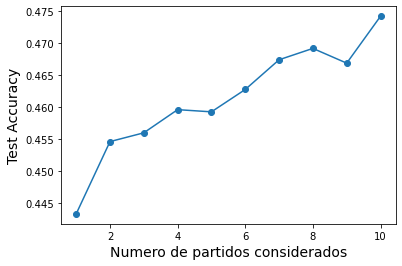

In [31]:
fffmp.plot_report_table(Report,'accuracy test',np.arange(1,11),'Numero de partidos considerados','Test Accuracy')

In [32]:
Report

,loss train,loss test,accuracy train,accuracy test,auc train,auc test,f1_score train,f1_score test
Todas features + Partidos1,0.429992,0.400651,0.443235,0.443302,0.633936,0.634066,0.437524,0.437565
Todas features + Partidos2,0.432495,0.403473,0.454400,0.454612,0.643189,0.643462,0.450390,0.450570
Todas features + Partidos3,0.434792,0.405922,0.455813,0.455984,0.644442,0.644774,0.449545,0.449658
Todas features + Partidos4,0.436663,0.407931,0.459379,0.459606,0.648297,0.648719,0.455857,0.456074
Todas features + Partidos5,0.436026,0.407286,0.458923,0.459264,0.649507,0.650026,0.457660,0.457978
Todas features + Partidos6,0.438977,0.410463,0.462467,0.462761,0.652019,0.652559,0.459245,0.459499
Todas features + Partidos7,0.441447,0.413018,0.466630,0.467407,0.655760,0.656518,0.457291,0.458022
Todas features + Partidos8,0.439679,0.411238,0.468631,0.469184,0.658155,0.658916,0.467712,0.468242
Todas features + Partidos9,0.440332,0.411832,0.466304,0.466878,0.656702,0.657485,0.460935,0.461489
Todas features + Partidos10,0.438572,0.410082,0.473534,0.474212,0.660336,0.661161,0.472463,0.473104


Dado que para 10 partidos encontramos los mejores resultados, procedemos a realizar todos los plots para ese modelo:  

Train shape: (83622, 10, 8)
Test shape: (10292, 10, 8)
Train shape: (83622, 10, 8)
Test shape: (10292, 10, 8)
Train shape: (83622, 7)
Test shape: (10292, 7)
Model: "Modelo_IFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 8)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 10, 10)       720         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                 

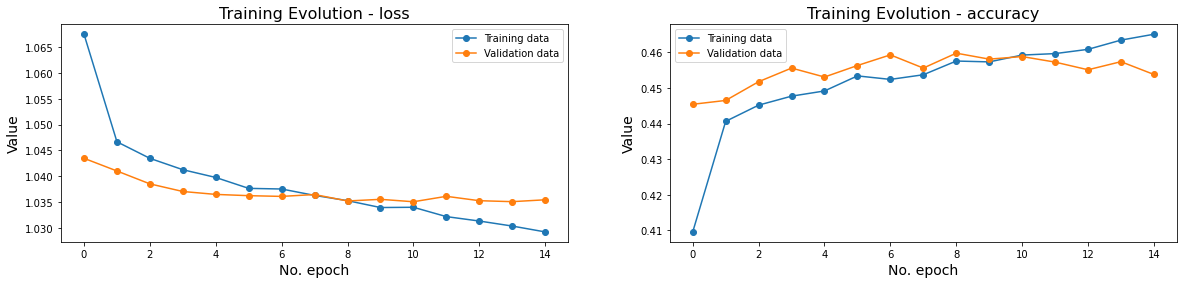

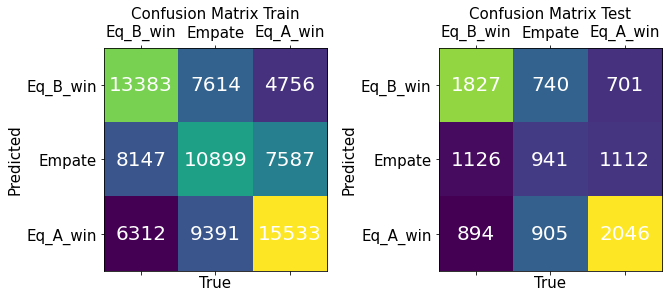

,Eq_B_win_train,Empate_train,Eq_A_win_train,micro avg,macro avg,weighted avg,samples avg
precision,0.519668,0.409229,0.497279,0.476131,0.475392,0.475352,0.476131
recall,0.480677,0.390589,0.557218,0.476131,0.476161,0.476131,0.476131
f1-score,0.499412,0.399692,0.525545,0.476131,0.474883,0.474848,0.476131
support,27842.000000,27904.000000,27876.000000,83622.000000,83622.000000,83622.000000,83622.000000


,Eq_B_win_test,Empate_test,Eq_A_win_test,micro avg,macro avg,weighted avg,samples avg
precision,0.559058,0.296005,0.532120,0.467742,0.462394,0.482862,0.467742
recall,0.474916,0.363882,0.530189,0.467742,0.456329,0.467742,0.467742
f1-score,0.513563,0.326453,0.531153,0.467742,0.457056,0.473144,0.467742
support,3847.000000,2586.000000,3859.000000,10292.000000,10292.000000,10292.000000,10292.000000


In [33]:
n_partidos=10
F_h=['play_home','is_cup','rating_diff','goal_diff','coach_continuity','relevance','is_friendly','corrected_rating_diff']
#_h=['play_home','goal_diff','rating_diff','is_friendly','coach_continuity']

M_A,M_A_test=fffmp.generate_input_for_RNN(X_train,X_test,F_h,['Equipo_A'],n_partidos,standarize=True)
M_B,M_B_test=fffmp.generate_input_for_RNN(X_train,X_test,F_h,['Equipo_B'],n_partidos,standarize=True)

N_Features=['Rating_diff','EqA_Local','is_cup','Equipo_A_coach_continuity','Equipo_B_coach_continuity','Descanso_entre_partidos_relativo','is_friendly']
H_Features=[]
A_train,A_test=fffmp.generate_input_for_NN(X_train,X_test,H_Features,N_Features,standarize=True) 

fffmp.clean_all_models()
time_steps=n_partidos
predictors=len(F_h)
tipo_RNN='LSTM'
recurrent_units=10
dense_units=[400,200,80,20,10]
dense_drop_out=0.1
out_shape=3
input_shape_history=(time_steps,predictors)
input_shape_now=A_train.shape[1]
metrics=['accuracy','AUC',F1]
IFA=fffmp.Create_Mix_Model(tipo_RNN ,recurrent_units, dense_units,dense_drop_out, out_shape, input_shape_history,input_shape_now,metrics)

batch_size = 200
epochs = 20
validation_split=0.1
y_train_pred,y_test_pred,Results=fffmp.Full_train_and_Report(IFA,[M_A,M_B,A_train],y_train,[M_A_test,M_B_test,A_test],y_test,batch_size,epochs,validation_split,num_classes=3,history_plot=True,confusion_matrix=True,Report_print=True)

Es interesante que al menos la matriz de confusion tiene los valores más altos todos en la diagonal para cada clase. Es un pequeño consuelo al menos.